In [55]:
# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
from uafgi import ioutil,shputil,greenland,bedmachine
import pyproj
import shapely
import copy
from uafgi import gicollections

#pd.set_option('display.max_rows', 30)

In [245]:

select = pd.read_pickle('select.df')
#selections[selections['popular_name'] == ]
row = select[select['w21_popular_name'] == 'Rink Isbrae'].to_dict('records')[0]
row

{'w21_popular_name': 'Rink Isbrae',
 'w21_greenlandic_name': 'Kangilliup Sermia',
 'w21_coast': 'CW',
 'w21_category': 'CR',
 'w21_Qr': 1.19,
 'w21_Qf': 1.08,
 'w21_Qm': 4.11,
 'w21_Qs': 0.2,
 'w21_Qc_inferred': nan,
 'w21_qm': nan,
 'w21_qf': 9.21,
 'w21_qc': nan,
 'w21_mean_depth': 568.0,
 'w21_min_depth': 424.0,
 'w21_quality_str': 'High',
 'w21_area_grounded_1992_2017': 5.24,
 'w21_area_grounded_1992_1997': 2.52,
 'w21_area_grounded_1998_2007': 1.52,
 'w21_area_grounded_2008_2017': 1.19,
 'w21_mean_fjord_width': 4.42,
 'w21_length_grounded_1992_2017': 1.19,
 'w21_length_grounded_1992_1997': 0.57,
 'w21_length_grounded_1998_2007': 0.34,
 'w21_length_grounded_2008_2017': 0.27,
 'w21_ocean_model_sample_area': 'CW1',
 'w21_mean_TF_1992-2017': 4.61,
 'w21_mean_TF_1992-1997': 3.77,
 'w21_mean_TF_1998-2007': 4.63,
 'w21_mean_TF_2008-2017': 5.04,
 'w21_subglacial_discharge_1992_2017': 4.0,
 'w21_subglacial_discharge_1992_1997': 2.59,
 'w21_subglacial_discharge_1998_2007': 4.0,
 'w21_subgla

In [246]:
ns642 = greenland.read_ns642(greenland.map_wkt)
ns642_dict = dict(list(ns642.df.groupby(by='ns642_GlacierID')))
ns642_this = ns642_dict[row['ns642_GlacierID']]
termini = ns642_this['ns642_terminus'].to_list()
termini

In [260]:
from uafgi import bedmachine,ogrutil
importlib.reload(bedmachine)
importlib.reload(ogrutil)

grid = row['ns481_grid']
grid_file = datasets.measures_grid_file(grid)
bedmachine_file = datasets.bedmachine_local(grid)

fjord = bedmachine.get_fjord(bedmachine_file, row['fj_poly'])
print(fjord.shape)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10e845ae0> >
(688, 789)


In [261]:


grid

'W71.65N'

In [262]:
from uafgi import gdalutil
importlib.reload(gdalutil)


# Get and extend the terminus line
term=termini[0]
term_extended=cgutil.extend_linestring(term, 100000.)



# Rasterize the terminus line
terminus_xr = gdalutil.rasterize_polygons(shapelyutil.to_datasource(term_extended), grid_file)
print(np.sum(np.sum(terminus_xr)))
print(terminus_xr.shape)


<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10e845ae0> >
678
(688, 789)


In [263]:
importlib.reload(gdalutil)
# Write as a raster
from osgeo import gdal
grid_info = gdalutil.FileInfo(grid_file)
#ds = gdalutil.clone_geometry('NetCDF', 'x.nc', grid_info, 1, gdal.GDT_Byte)
#ds.GetRasterBand(1).WriteArray(terminus_xr)
#ds.FlushCache()


In [264]:
import skimage.segmentation
# Place to seed our fill
seed = grid_info.to_ij(*row['loc'].coords[0])
#seed = (324,265)
print(seed)
#print(fjord.shape, terminus_xr.shape)
fj = np.zeros(fjord.shape)
fj[fjord] = 1
fj[terminus_xr != 0] = 2
seed = (seed[1],seed[0])
#fj[seed[0],seed[1]] = 4
print('seed ',seed, fj.shape)
selem = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]
])
upper = skimage.segmentation.flood(fj, seed, selem=selem)
fj[upper] = 4

ds = gdalutil.clone_geometry('NetCDF', 'x.nc', grid_info, 1, gdal.GDT_Byte)
ds.GetRasterBand(1).WriteArray(fj)
ds.FlushCache()


#fj = copy.copy(fjord)

#skimage.segmentation.

(179, 498)
seed  (498, 179) (688, 789)
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x112d53c30> >


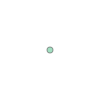

In [160]:
row['loc']

In [173]:
np.sum(np.sum(terminus_xr))
print(terminus_xr)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [274]:
from uafgi import glaciers,cgutil
importlib.reload(glaciers)
importlib.reload(gdalutil)
uf = glaciers.upstream_fjord(fjord, gdalutil.FileInfo(grid_file), row['up_loc'], term)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10e845f60> >


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [276]:
ds = gdalutil.clone_geometry('NetCDF', 'x.nc', grid_info, 1, gdal.GDT_Byte)
ds.GetRasterBand(1).WriteArray(uf)
ds.FlushCache()

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x1143c6e40> >


In [279]:
fb = gdalutil.FileInfo('data/bedmachine/BedMachineGreenland-2017-09-20.nc')
fb.y1-fb.y0

-2751900.0

In [281]:
fb = gdalutil.FileInfo('data/itslive/GRE_G0240_2014.nc')
fb.y1-fb.y0

-2728320.0

In [282]:
fb = gdalutil.FileInfo('outputs/bedmachine/BedMachineGreenland-2017-09-20_pism.nc')
fb.y1-fb.y0

2751900.0